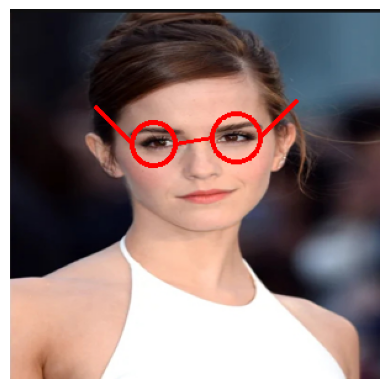

Image with glasses saved at: D:/Lab5ext\images\output_emma-watson2.jpg


In [52]:
import pandas as pd
import zipfile
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt

zip_file_path = 'D:/Lab5.zip'
extracted_folder = 'D:/Lab5ext'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

images_folder = os.path.join(extracted_folder, 'images')
data_file = os.path.join(extracted_folder, 'lab6.xlsx')

df = pd.read_excel(data_file)

variant_data = df[df['N'] == 1].iloc[0]
image_filename = variant_data['file name']

width, height = map(int, variant_data['image size'].split('x'))
image_size = (width, height)

glasses_color = variant_data['glasses color']
line_width = int(variant_data['line width'])

image_path = os.path.join(images_folder, image_filename)

def add_glasses_to_image(image_path, image_size, glasses_color, line_width):
    img = Image.open(image_path)
    img = img.resize(image_size)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = img_cv[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=10, minSize=(20, 20))
        
        if len(eyes) >= 2:
            eyes = sorted(eyes, key=lambda e: e[0])
            (ex1, ey1, ew1, eh1) = eyes[0] 
            (ex2, ey2, ew2, eh2) = eyes[1] 

            center_left = (x + ex1 + ew1 // 2, y + ey1 + eh1 // 2)
            center_right = (x + ex2 + ew2 // 2, y + ey2 + eh2 // 2)

            radius_left = max(ew1, eh1) // 2 + 5
            radius_right = max(ew2, eh2) // 2 + 5

            color = (0, 0, 255) if glasses_color.lower() == "red" else (0, 255, 0)  

            cv2.circle(img_cv, center_left, radius_left, color, line_width)
            cv2.circle(img_cv, center_right, radius_right, color, line_width)

            start_point = (center_left[0] + radius_left, center_left[1])  
            end_point = (center_right[0] - radius_right, center_right[1])  

            cv2.line(img_cv, start_point, end_point, color, line_width)

            frame_radius_left = radius_left + line_width // 2
            frame_radius_right = radius_right + line_width // 2

            cv2.circle(img_cv, center_left, frame_radius_left, color, line_width)
            cv2.circle(img_cv, center_right, frame_radius_right, color, line_width)

            left_arm_start = (center_left[0] - radius_left, center_left[1]) 
            left_arm_end = (left_arm_start[0] - 30, left_arm_start[1] - 30)  

            right_arm_start = (center_right[0] + radius_right, center_right[1])  
            right_arm_end = (right_arm_start[0] + 30, right_arm_start[1] - 30) 

            cv2.line(img_cv, left_arm_start, left_arm_end, color, line_width)
            cv2.line(img_cv, right_arm_start, right_arm_end, color, line_width)

    img_result = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

    output_filename = f'output_{os.path.basename(image_path)}'
    output_path = os.path.join(images_folder, output_filename)
    img_result.save(output_path)

    plt.imshow(img_result)
    plt.axis('off')
    plt.show()

    return output_path

output_image_path = add_glasses_to_image(image_path, image_size, glasses_color, line_width)
print(f"Image with glasses saved at: {output_image_path}")
